<a href="https://colab.research.google.com/github/ned717/UW-Madison-ALP-Computer-Science/blob/main/Final_Week_3_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wake of Water Around a Cylinder

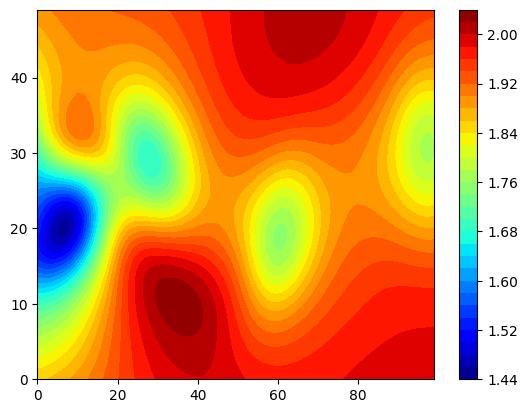

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

nu = 0.01

class NavierStokes():
    def __init__(self, X, Y, T, u, v):

        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True)

        self.u = torch.tensor(u, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)

        #null vector to test against f and g:
        self.null = torch.zeros((self.x.shape[0], 1))

        # initialize network:
        self.network()b

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        self.mse = nn.MSELoss()

        #loss
        self.ls = 0

        #iteration number
        self.iter = 0

    def network(self):

        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2))

    def function(self, x, y, t):

        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]

        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0] #retain_graph=True,
        v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()

        # u, v, p, g and f predictions:
        u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)

        # calculate losses
        u_loss = self.mse(u_prediction, self.u)
        v_loss = self.mse(v_prediction, self.v)
        f_loss = self.mse(f_prediction, self.null)
        g_loss = self.mse(g_prediction, self.null)
        self.ls = u_loss + v_loss + f_loss +g_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):

        # training loop
        self.net.train()
        self.optimizer.step(self.closure)

N_train = 5000

data = scipy.io.loadmat('cylinder_wake.mat')

U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

'''
pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)

pinn.train()

torch.save(pinn.net.state_dict(), 'model.pt')
'''

pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)

u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()
plt.show()

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, i*t_test)
    u_plot = p_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'$p(x,\; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
ani.save('wake.gif')
plt.close()
# Display the plot
plt.show()

# Airflow Around an Airfoil

Set the default float type to float64
Compiling model...
Building feed-forward neural network...
'build' took 0.173404 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.629943 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.04e-02, 1.87e-02, 7.66e-03, 7.02e-02, 1.53e-01, 1.38e-02, 4.32e-01, 3.22e-01, 3.21e-01, 8.21e-03]    [1.05e-02, 1.81e-02, 7.43e-03, 7.02e-02, 1.53e-01, 1.38e-02, 4.32e-01, 3.22e-01, 3.21e-01, 8.21e-03]    []  
10        [9.78e-04, 1.06e-03, 8.73e-03, 3.01e-02, 1.53e-02, 1.18e-02, 4.10e-02, 2.18e-02, 2.04e-02, 1.50e-03]    [1.02e-03, 9.72e-04, 8.00e-03, 3.01e-02, 1.53e-02, 1.18e-02, 4.10e-02, 2.18e-02, 2.04e-02, 1.50e-03]    []  
20        [6.99e-04, 1.97e-03, 4.75e-04, 7.19e-03, 2.49e-03, 1.08e-03, 4.81e-03, 2.57e-02, 5.61e-03, 4.98e-04]    [6.49e-04, 1.79e-03, 4.19e-04, 7.19e-03, 2.49e-03, 1.08e-03, 4.81e-03, 2.57e-02, 5.61e-03, 4.98e-04]    []  
30        [6.58e-04, 5.11e-04, 2.44e-03, 3.24e-03, 4.26

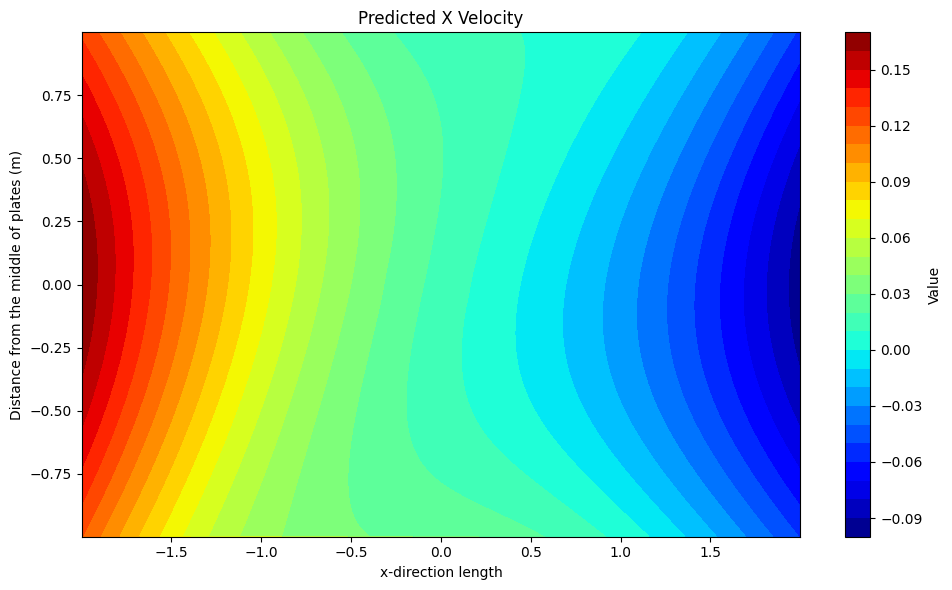

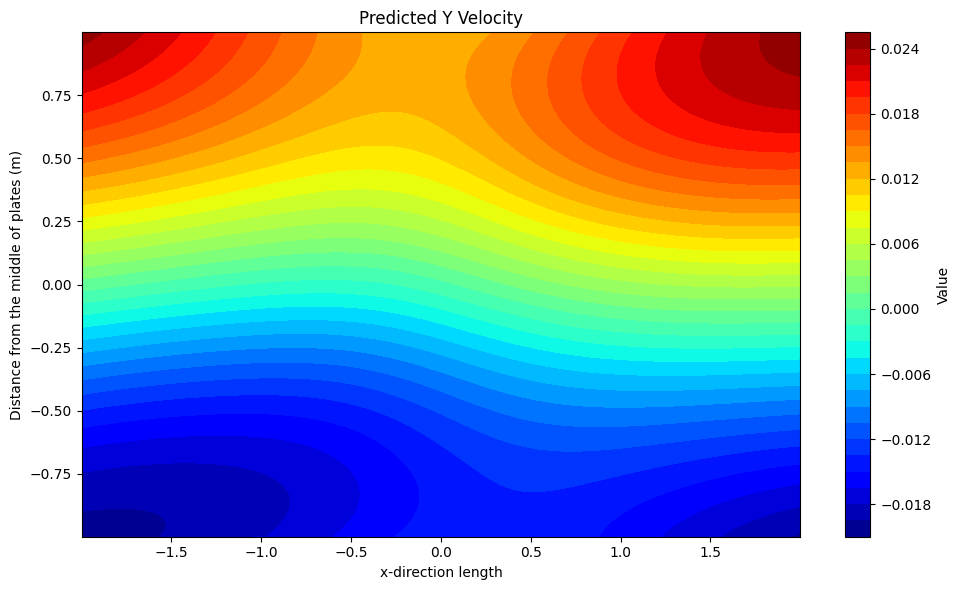

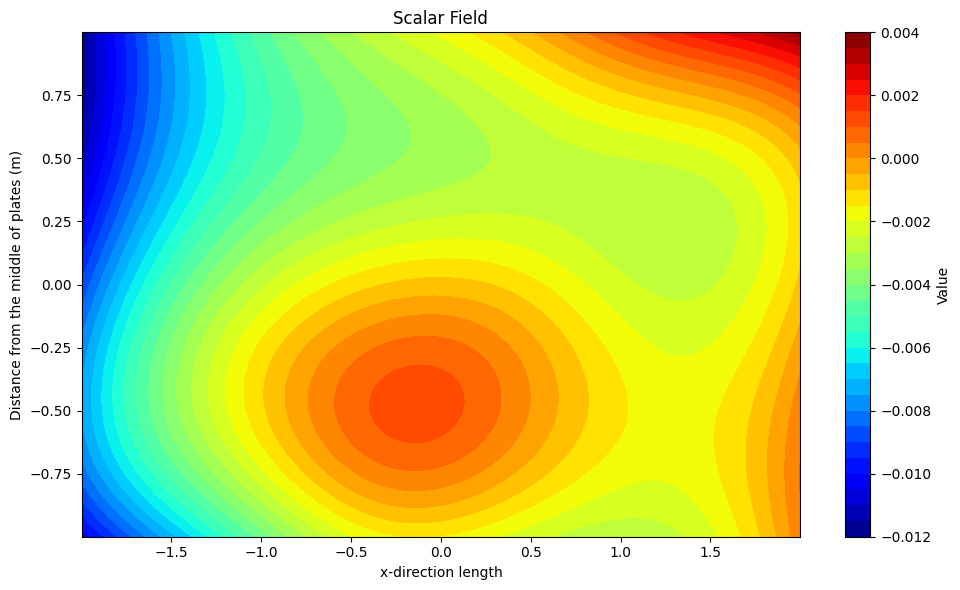

In [ ]:
# Import Libraries
!pip install deepxde
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

# Set random seed for reproducibility
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

# Properties
rho = 1 # Density
mu = 0.01 # Viscosity
u_max = 0.3 # Max Veloccity
L = 4  # Boundary length
H = 2  # Boundary height
angle = 10  # Attack angle of airfoil

# Airfoil Data input
data_str = """1.0000     0.00252
0.9500     0.01613
0.9000     0.02896
0.8000     0.05247
0.7000     0.07328
0.6000     0.09127
0.5000     0.10588
0.4000     0.11607
0.3000     0.12004
0.2500     0.11883
0.2000     0.11475
0.1500     0.10691
0.1000     0.09365
0.0750     0.08400
0.0500     0.07109
0.0250     0.05229
0.0125     0.03788
0.0000     0.00000
0.0125     -0.03788
0.0250     -0.05229
0.0500     -0.07109
0.0750     -0.08400
0.1000     -0.09365
0.1500     -0.10691
0.2000     -0.11475
0.2500     -0.11883
0.3000     -0.12004
0.4000     -0.11607
0.5000     -0.10588
0.6000     -0.09127
0.7000     -0.07328
0.8000     -0.05247
0.9000     -0.02896
0.9500     -0.01613
1.0000     -0.00252
"""

# Process and Rotate Airfoil
def rotate_coordinates(coordinates, angle):
    theta = np.radians(angle) # Angle to Radians
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    rotated_coordinates = np.dot(coordinates, rotation_matrix)
    return rotated_coordinates

# Convert the string to a list of lists, splitting by whitespace
data_list = [list(map(float, line.split())) for line in data_str.strip().split('\n')]

# Convert the list of lists to a numpy array
array = np.array(data_list)
array[:, 0] = array[:, 0] - 0.5
array = rotate_coordinates(array, angle)

# Boundary Conditions
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -H/2), np.isclose(X[1], H/2)), on_boundary)
    return on_wall

def boundary_airfoil(X, on_boundary):
    on_airfoil = np.logical_and(np.isclose(array, X, atol=0.01).any(), on_boundary)
    return on_airfoil

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

# Define Navier Stokes PDE
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    du_xx = dde.grad.hessian(Y, X, i=1, j=0, component=0)
    du_yy = dde.grad.hessian(Y, X, i=1, j=1, component=0)
    dv_xx = dde.grad.hessian(Y, X, i=1, j=0, component=1)
    dv_yy = dde.grad.hessian(Y, X, i=1, j=1, component=1)

    pde_u = Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

# Geometry Setup
windtunnel = dde.geometry.Rectangle(xmin=[-L/2, -H/2], xmax=[L/2, H/2])
airfoil = dde.geometry.geometry_2d.Polygon(array)

geom = dde.geometry.csg.CSGDifference(windtunnel, airfoil)

# Boundary Points
inner_rec = dde.geometry.Rectangle([-0.75, -H/4], [0.75, H/4])
outer_dom = dde.geometry.CSGDifference(windtunnel, inner_rec)
outer_dom = dde.geometry.CSGDifference(outer_dom, airfoil)
inner_dom = dde.geometry.CSGDifference(inner_rec, airfoil)

inner_points = inner_dom.random_points(6000)
outer_points = outer_dom.random_points(10000)
windtunnel_points = windtunnel.random_boundary_points(1500)
airfoil_points = airfoil.random_boundary_points(800)

points = np.append(inner_points, outer_points, axis=0)
points = np.append(points, windtunnel_points, axis=0)
points = np.append(points, airfoil_points, axis=0)

# Define Velocity Function
def fun_inlet_u(X):
    return u_max * (1 - (2 * X[:, 1] / H) ** 2)

inlet_points = np.array([[-L/2, y] for y in np.linspace(-H/2, H/2, 100)])

# Boundary Conditions
bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component=1)
bc_airfoil_u = dde.DirichletBC(geom, lambda X: 0., boundary_airfoil, component=0)
bc_airfoil_v = dde.DirichletBC(geom, lambda X: 0., boundary_airfoil, component=1)
bc_inlet_u = dde.DirichletBC(geom, lambda X: fun_inlet_u(X), boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component=1)
bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component=2)

bcs = [bc_wall_u, bc_wall_v, bc_airfoil_u, bc_airfoil_v, bc_inlet_u, bc_inlet_v, bc_outlet_p]

# Data Collection
data = dde.data.PDE(geom,
                    pde,
                    bcs,
                    num_domain=10000,
                    num_boundary=3000,
                    num_test=6000,
                    train_distribution='Hammersley')

# Plot Function
def plot_results(samples, result, idx, color_legend):
    plt.figure(figsize=(10, 6))
    plt.triplot(array[:, 0], array[:, 1], color='black')
    plt.tricontourf(samples[:, 0], samples[:, 1], result[:, idx], levels=30, cmap='jet')
    plt.colorbar(label='Value')
    plt.xlabel('x-direction length')
    plt.ylabel('Distance from the middle of plates (m)')

    # Adding title based on idx
    if idx == 0:
        plt.title('Predicted X Velocity')
    elif idx == 1:
        plt.title('Predicted Y Velocity')
    elif idx == 2:
        plt.title('Scalar Field')

    plt.tight_layout()

# Neural Network Setup
layer_size = [2] + [40] * 8 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

# Create and Compile the Model
model = dde.Model(data, net)
model.compile("adam", lr=5e-4, loss_weights=[1, 1, 1, 1, 1, 1, 9, 1, 1, 1])

# Training the Model
losshistory, train_state = model.train(epochs=150, display_every=10)

# Prediction and Plotting
samples = geom.random_points(300000)
result = model.predict(samples)

# Graph
color_legend = [[-0.1, 0.35], [-0.1, 0.15], [-0.15, 0.15]]
for idx in range(3):
    plot_results(samples, result, idx, color_legend)

plt.show()
